In [ ]:
# -----------------------STEP 1------------------------
# This is the code for image reading and pre-processing
# ----------------------STEP 1------------------------

import numpy as np
from PIL import Image
import os

def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        print(f"Processing image: {path}")
        img = Image.open(path)
        
        # Convert grayscale image to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values
        #print(f"Image shape after resizing: {img_array.shape}")
        images.append(img_array)
    return np.array(images)

# Path to the folder containing images
image_folder_clean = os.path.join("mix", "clean")
image_folder_dirty = os.path.join("mix", "dirty")

# Get list of image paths for clean and dirty images
image_paths_clean = []
for root, dirs, files in os.walk(image_folder_clean):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            image_paths_clean.append(os.path.join(root, file))

image_paths_dirty = []
for root, dirs, files in os.walk(image_folder_dirty):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            image_paths_dirty.append(os.path.join(root, file))

# Resize and preprocess clean images
images_clean = preprocess_images(image_paths_clean)
# Resize and preprocess dirty images
images_dirty = preprocess_images(image_paths_dirty)

In [2]:
# ---------------------------STEP 2------------------------
# Encoding the pre-processed images with pre-trained models
# ---------------------------STEP 2------------------------
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, ResNet101, ResNet152,
    DenseNet121, DenseNet169, DenseNet201,
    MobileNet, MobileNetV2,
    Xception, InceptionV3, InceptionResNetV2,
    NASNetLarge, NASNetMobile,
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4
)

# Define function to encode images using a pre-trained model
def encode_images(model, images):
    encoded_images = model.predict(images)
    encoded_images_flattened = encoded_images.reshape(encoded_images.shape[0], -1)
    return encoded_images_flattened


pretrained_models = {
    "VGG16": VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "VGG19": VGG19(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "ResNet50": ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "ResNet101": ResNet101(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "ResNet152": ResNet152(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "InceptionV3": InceptionV3(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "InceptionResNetV2": InceptionResNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "Xception": Xception(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "MobileNet": MobileNet(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "MobileNetV2": MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "DenseNet121": DenseNet121(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "DenseNet169": DenseNet169(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "DenseNet201": DenseNet201(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "NASNetMobile": NASNetMobile(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "NASNetLarge": NASNetLarge(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "EfficientNetB1": EfficientNetB1(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "EfficientNetB2": EfficientNetB2(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "EfficientNetB3": EfficientNetB3(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    "EfficientNetB4": EfficientNetB4(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
}
# Combine clean and dirty images
images = np.concatenate((images_clean, images_dirty))
# Create labels (0 for clean, 1 for dirty)
labels = np.concatenate((np.zeros(len(images_clean)), np.ones(len(images_dirty))))
base_path = os.path.join("mix", "encoded_images")
os.mkdir(base_path)

# Loop through each pre-trained model
for model_name, model in pretrained_models.items():
    # Encode clean images using the current model
    print(f"Encoding CLEAN images with {model_name}")
    encoded_images_clean = encode_images(model, images_clean)
    # Encode dirty images using the current model
    print(f"Encoding DIRTY images with {model_name}")
    encoded_images_dirty = encode_images(model, images_dirty)
    
    # Save the encoded images and labels
    # Define the directory structure
    save_path = os.path.join("mix", "encoded_images", model_name)
    # Create directories if they do not exist
    os.mkdir(save_path)
    # File path for saving the numpy array
    clean_file_path = os.path.join(save_path, "clean.npy")
    np.save(clean_file_path, encoded_images_clean)
    
    #save_path_dirty = os.path.join("mix", "encoded_images", model_name)
    dirty_file_path = os.path.join(save_path, "dirty.npy")
    np.save(dirty_file_path, encoded_images_dirty)
    
    print(f"Encoded images saved for {model_name}")

print("Encoding completed.")

In [93]:
#---------------------------STEP3-------------------------
#                      Classification 
#---------------------------------------------------------
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to train and evaluate SVM
def train_and_evaluate_SVM(X_train, X_test, y_train, y_test):
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM; Change the kernels with the following options
    #Linear Kernel: 'linear'
    #Polynomial Kernel: 'poly'
    #Radial Basis Function (RBF) Kernel: 'rbf'
    #Sigmoid Kernel: 'sigmoid'
    #Precomputed Kernel: 'precomputed'

    svm = SVC(kernel='linear')
    svm.fit(X_train_scaled, y_train)

    # Predict labels
    y_pred = svm.predict(X_test_scaled)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)

    return accuracy, precision, recall, f1, tpr,tp, tn, fp, fn

# Define function to save results to CSV
def save_results_to_csv(model_name, fold_nu, accuracy, precision, recall, f1, tpr, tp, tn, fp, fn):
    data = {'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1 Score': [f1],
            'True Positive Rate': [tpr],
            'True Positive': [tp],
            'True Negative': [tn],
            'False Positive': [fp],
            'False Negative': [fn]}
    df = pd.DataFrame(data)
    df.to_csv(f"{model_name}-fold{fold_nu}.csv", index=False)

# Loop through each pre-trained model
from sklearn.model_selection import StratifiedKFold
import pandas as pd
for model_name, model in pretrained_models.items():
    # Initialize lists to store results for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    tpr_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    # Load encoded images
    print(f"loading clean images of {model_name}")
    encoded_images_clean = np.load(os.path.join("mix", "encoded_images", model_name, "clean.npy"))
    print(f"loading dirty images of {model_name}")
    encoded_images_dirty = np.load(os.path.join("mix", "encoded_images", model_name, "dirty.npy"))

    # Combine clean and dirty encoded images
    encoded_images = np.concatenate((encoded_images_clean, encoded_images_dirty))

    # Create labels
    labels = np.concatenate((np.zeros(len(encoded_images_clean)), np.ones(len(encoded_images_dirty))))

    # Perform 5-fold cross-validation

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    
    fold_nu = 1
    for train_index, test_index in skf.split(encoded_images, labels):
        X_train, X_test = encoded_images[train_index], encoded_images[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Train and evaluate SVM
        print(f"Training and evaluating SVM for {model_name} in {str(fold_nu)}")
        #accuracy, precision, recall, f1, tpr, tp, tn, fp, fn = train_and_evaluate_SVM_helinger(X_train, X_test, y_train, y_test)
        accuracy, precision, recall, f1, tpr, tp, tn, fp, fn = train_and_evaluate_SVM(X_train, X_test, y_train, y_test)

        # Save results to CSV
        print(f"Saving result for {model_name} in {str(fold_nu)}")
        save_results_to_csv(model_name, fold_nu, accuracy, precision, recall, f1, tpr, tp, tn, fp, fn)

        # Append results to lists
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        tpr_list.append(tpr)
        tp_list.append(tp)
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)

        fold_nu += 1

    # Calculate mean and standard deviation of results
    print(f"Calculating mean result for {model_name}")
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mean_tpr = np.mean(tpr_list)
    std_tpr = np.std(tpr_list)
    mean_tp = np.mean(tp_list)
    std_tp = np.std(tp_list)
    mean_tn = np.mean(tn_list)
    std_tn = np.std(tn_list)
    mean_fp = np.mean(fp_list)
    std_fp = np.std(fp_list)
    mean_fn = np.mean(fn_list)
    std_fn = np.std(fn_list)

    # Save mean results to final CSV file
    mean_results = {'Metric': ['Classification Accuracy', 'Precision', 'Recall', 'F1 Score', 'True Positive Rate',
                               'True Positive', 'True Negative', 'False Positive', 'False Negative'],
                    'Mean': [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_tpr, mean_tp, mean_tn, mean_fp, mean_fn],
                    'Standard Deviation': [std_accuracy, std_precision, std_recall, std_f1, std_tpr, std_tp, std_tn, std_fp, std_fn]}
    mean_results_df = pd.DataFrame(mean_results)
    mean_results_df.to_csv(f"{model_name}-final-result.csv", index=False)

loading clean images of VGG16
loading dirty images of VGG16
Training and evaluating SVM for VGG16 in 1
Saving result for VGG16 in 1
Training and evaluating SVM for VGG16 in 2
Saving result for VGG16 in 2
Training and evaluating SVM for VGG16 in 3
Saving result for VGG16 in 3
Training and evaluating SVM for VGG16 in 4
Saving result for VGG16 in 4
Training and evaluating SVM for VGG16 in 5
Saving result for VGG16 in 5
Calculating mean result for VGG16
loading clean images of VGG19
loading dirty images of VGG19
Training and evaluating SVM for VGG19 in 1
Saving result for VGG19 in 1
Training and evaluating SVM for VGG19 in 2
Saving result for VGG19 in 2
Training and evaluating SVM for VGG19 in 3
Saving result for VGG19 in 3
Training and evaluating SVM for VGG19 in 4
Saving result for VGG19 in 4
Training and evaluating SVM for VGG19 in 5
Saving result for VGG19 in 5
Calculating mean result for VGG19
loading clean images of ResNet50
loading dirty images of ResNet50
Training and evaluating SV

In [95]:
#---------------------------STEP 4------------------------
#                      Saving RESULTS 
#---------------------------------------------------------
import pandas as pd
import glob

# List all final result CSV files
csv_files = glob.glob("*-final-result.csv")

# Initialize an empty list to store dataframes
dfs = []

# Iterate over CSV files
for csv_file in csv_files:
    # Read CSV file into a dataframe
    df = pd.read_csv(csv_file)
    # Add model name as a column
    model_name = csv_file.split('-')[0]
    df['Model'] = model_name
    # Append dataframe to the list
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)
# Multiply each entry in the "Mean" column by 100 and round to 2 decimal places
combined_df['Mean'] = (combined_df['Mean'] * 100).round(2)
# Save the combined_df dataframe to an Excel file named "all_results.xlsx"
combined_df.to_excel("all_results_sigmoid.xlsx", index=False)
# Separating the results
accuracies_df = combined_df[combined_df['Metric'] == 'Classification Accuracy']
precision_df = combined_df[combined_df['Metric'] == 'Precision']
recall_df = combined_df[combined_df['Metric'] == 'Recall']
f1_df = combined_df[combined_df['Metric'] == 'F1 Score']
trp_df = combined_df[combined_df['Metric'] == 'True Positive Rate']

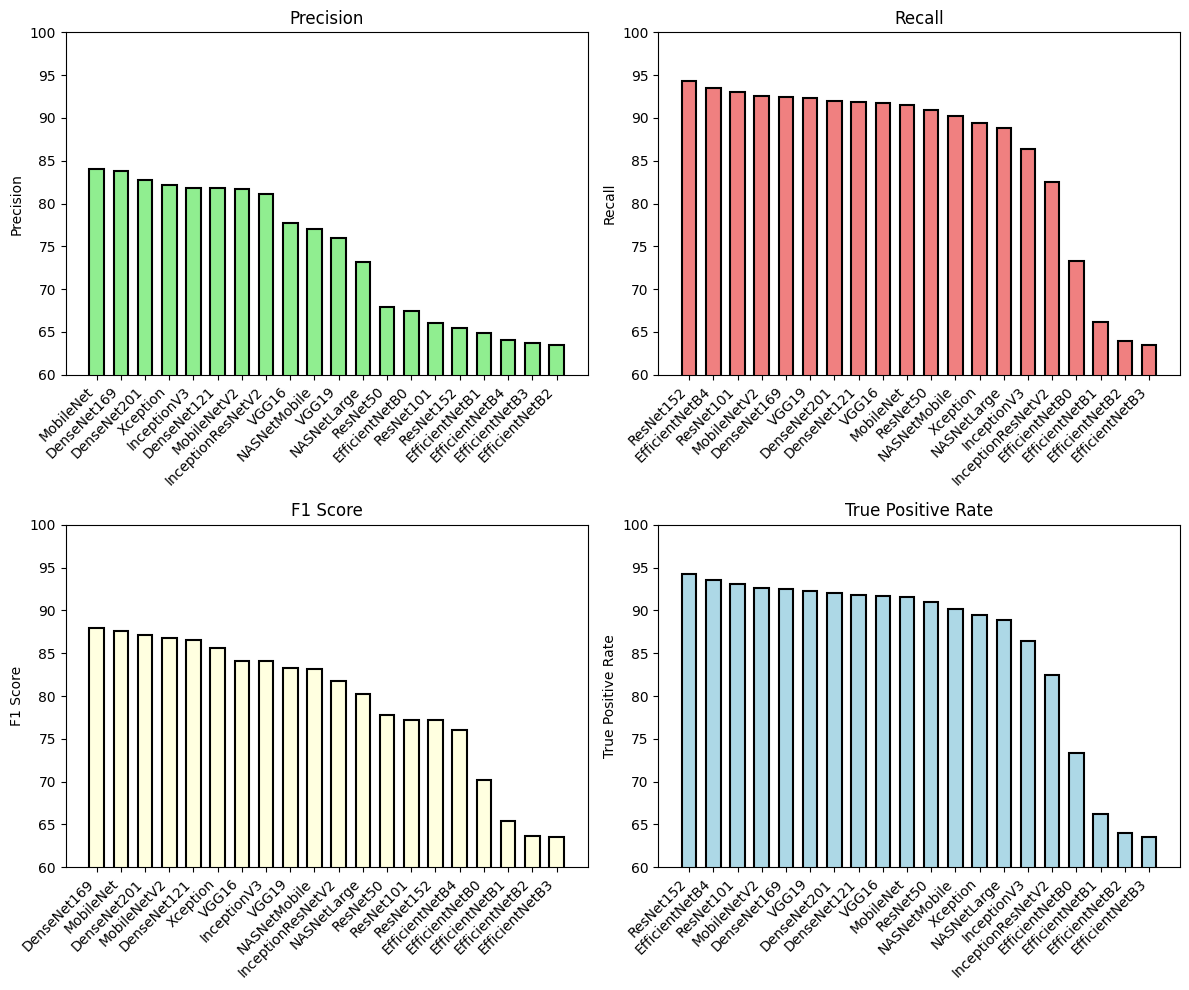

In [96]:
#---------------------------STEP 5------------------------
#                   Visualizing the results
#---------------------------------------------------------
import matplotlib.pyplot as plt
# Sort the dataframes in descending order by 'Mean' column

precision_df = precision_df.sort_values(by='Mean', ascending=False)
recall_df = recall_df.sort_values(by='Mean', ascending=False)
f1_df = f1_df.sort_values(by='Mean', ascending=False)
trp_df = trp_df.sort_values(by='Mean', ascending=False)

# Create a figure and subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Precision and Recall in the first row
ax = axes[0, 0]
ax.bar(precision_df['Model'], precision_df['Mean'], color='lightgreen', edgecolor='black', linewidth=1.5, width=0.6)
ax.set_title('Precision')
ax.set_ylabel('Precision')
ax.set_ylim(60, 100)
ax.set_xticks(range(len(precision_df['Model'])))  # Set the x-axis ticks
ax.set_xticklabels(precision_df['Model'], rotation=45, ha='right')  # Rotate x-axis labels

ax = axes[0, 1]
ax.bar(recall_df['Model'], recall_df['Mean'], color='lightcoral', edgecolor='black', linewidth=1.5, width=0.6)
ax.set_title('Recall')
ax.set_ylabel('Recall')
ax.set_ylim(60, 100)
ax.set_xticks(range(len(recall_df['Model'])))  # Set the x-axis ticks
ax.set_xticklabels(recall_df['Model'], rotation=45, ha='right')  # Rotate x-axis labels

# Plot F1 Score and True Positive Rate in the second row
ax = axes[1, 0]
ax.bar(f1_df['Model'], f1_df['Mean'], color='lightyellow', edgecolor='black', linewidth=1.5, width=0.6)
ax.set_title('F1 Score')
ax.set_ylabel('F1 Score')
ax.set_ylim(60, 100)
ax.set_xticks(range(len(f1_df['Model'])))  # Set the x-axis ticks
ax.set_xticklabels(f1_df['Model'], rotation=45, ha='right')  # Rotate x-axis labels

ax = axes[1, 1]
ax.bar(trp_df['Model'], trp_df['Mean'], color='lightblue', edgecolor='black', linewidth=1.5, width=0.6)
ax.set_title('True Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_ylim(60, 100)
ax.set_xticks(range(len(trp_df['Model'])))  # Set the x-axis ticks
ax.set_xticklabels(trp_df['Model'], rotation=45, ha='right')  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
# Save the plot as a PDF file with high quality and no extra margins
plt.savefig('bar_plots_sigmoid.pdf', bbox_inches='tight', dpi=400)
# Show the plot
plt.show()

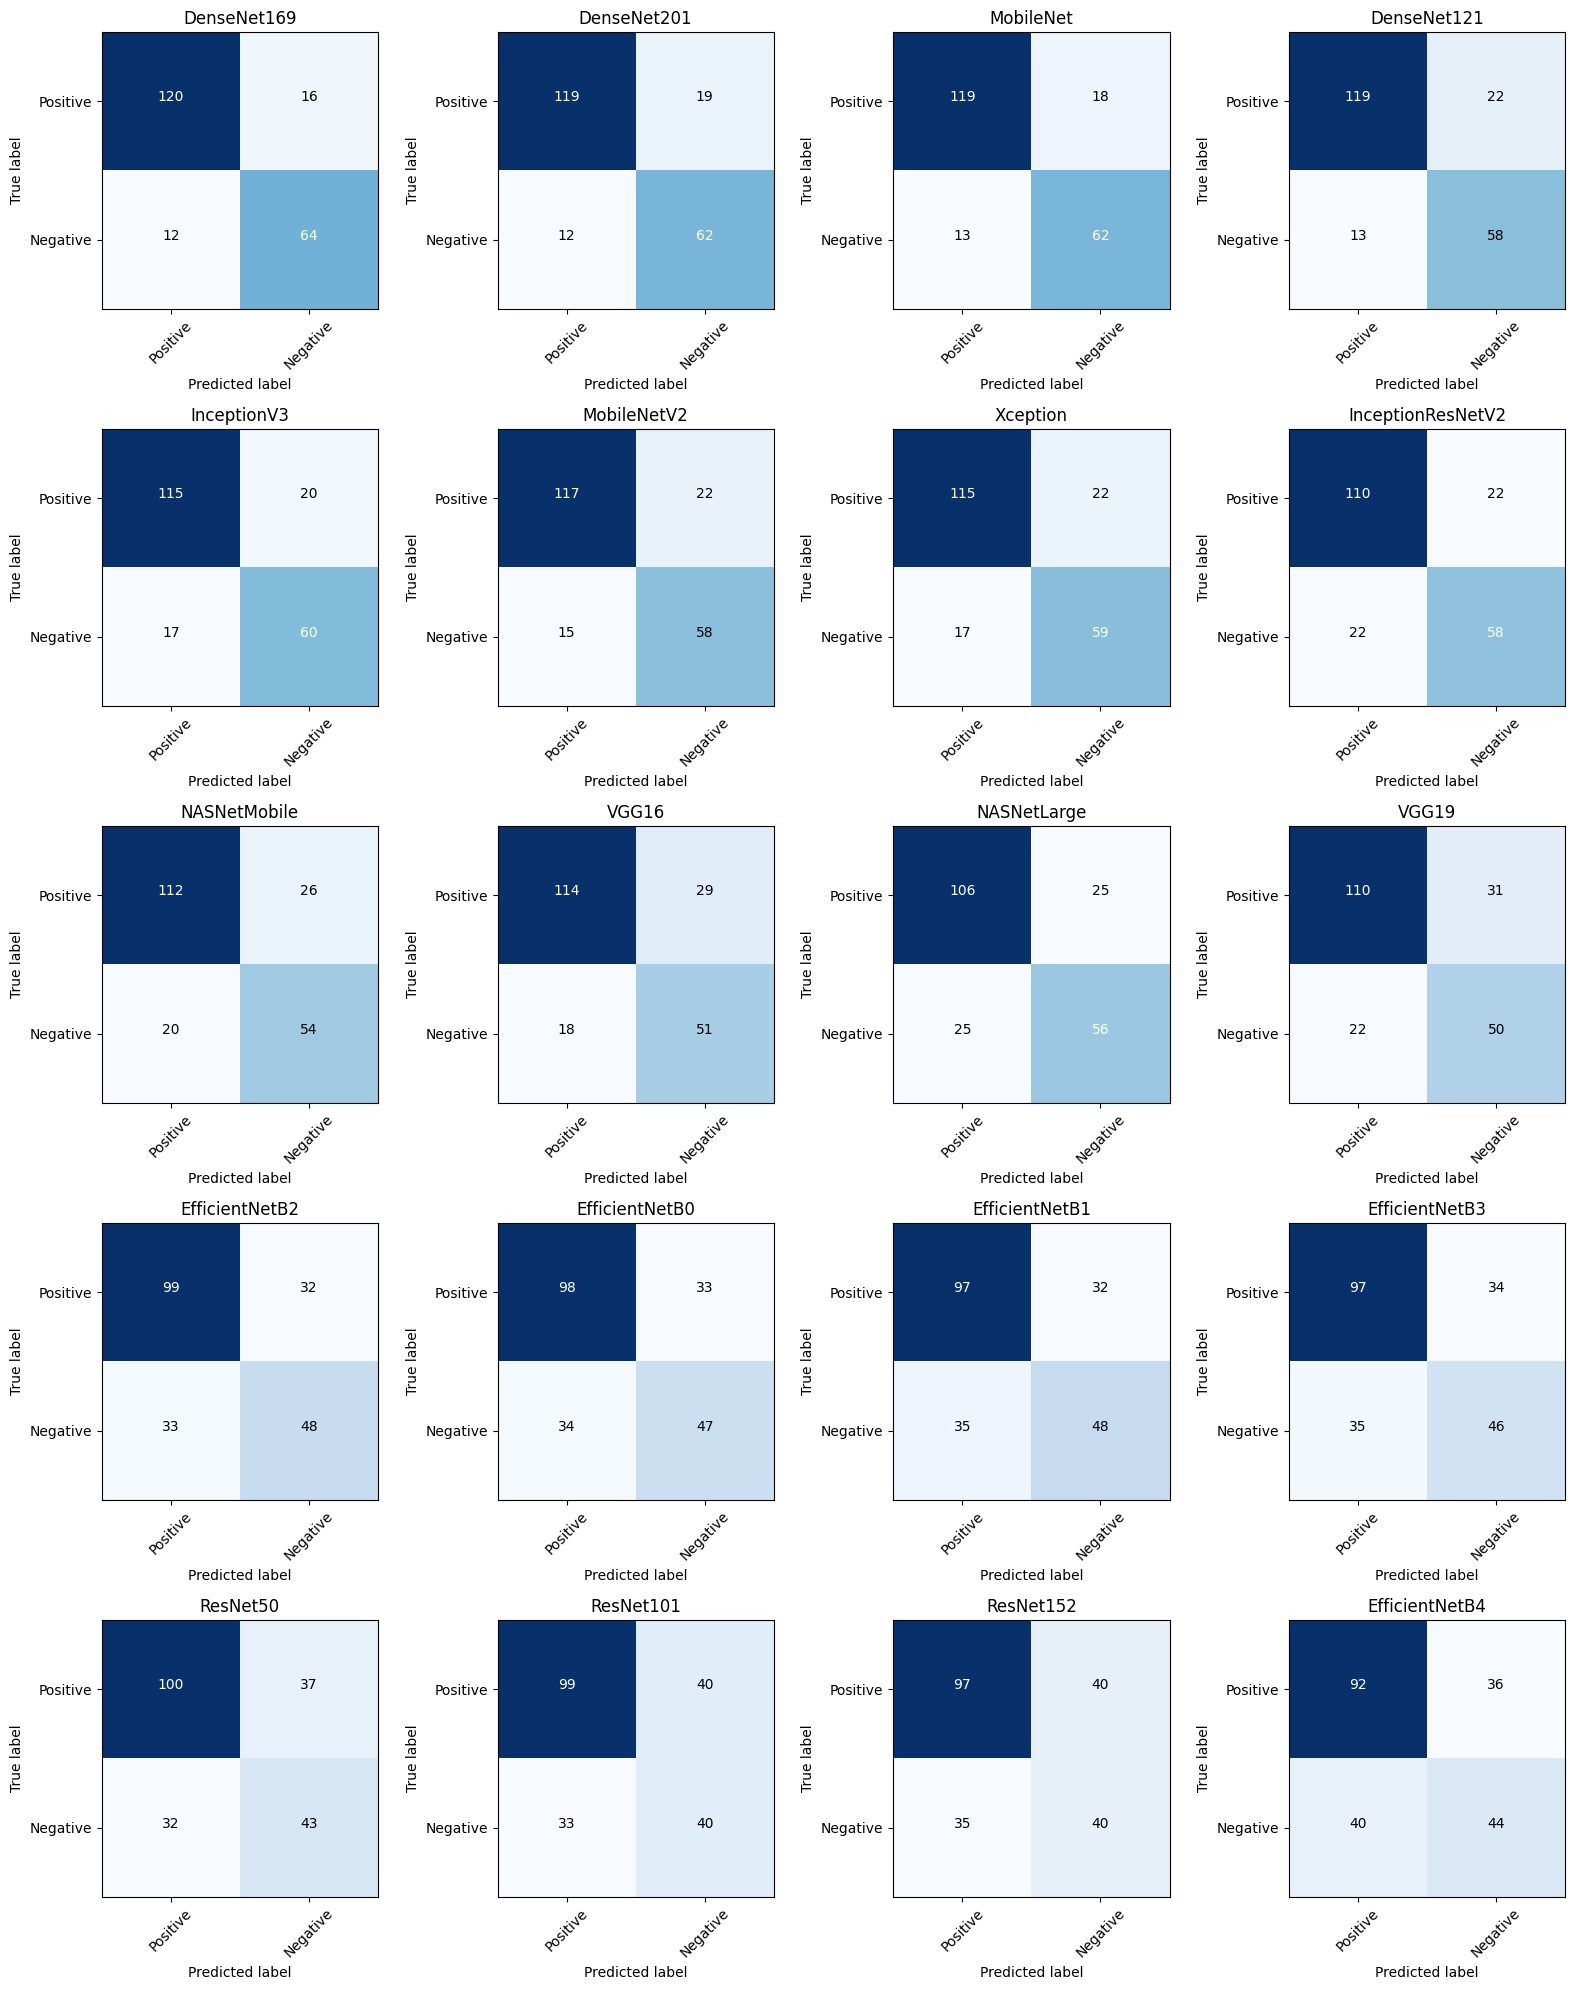

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Step 1: Read the Excel file into a DataFrame
df = pd.read_excel("results/all_results_linear.xlsx")

# Step 2: Extract rows where the Metric names are True Positive, True Negative, False Positive, and False Negative
metric_names = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
confusion_matrix_data = df[df['Metric'].isin(metric_names)]

# Calculate classification accuracy for each model
accuracy_dict = {}
for model_name in confusion_matrix_data['Model'].unique():
    model_data = confusion_matrix_data[confusion_matrix_data['Model'] == model_name]
    tp = model_data[model_data['Metric'] == 'True Positive']['Mean'].iloc[0]
    tn = model_data[model_data['Metric'] == 'True Negative']['Mean'].iloc[0]
    fp = model_data[model_data['Metric'] == 'False Positive']['Mean'].iloc[0]
    fn = model_data[model_data['Metric'] == 'False Negative']['Mean'].iloc[0]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracy_dict[model_name] = accuracy

# Sort models by classification accuracy
sorted_models = sorted(accuracy_dict.items(), key=lambda x: x[1], reverse=True)

# Set up the figure and axes
num_models = len(sorted_models)
num_rows = num_models // 4 + (1 if num_models % 4 != 0 else 0)
fig, axes = plt.subplots(num_rows, 4, figsize=(16, num_rows*4))

# Iterate through each model and plot its confusion matrix
for i, (model_name, _) in enumerate(sorted_models):
    # Get confusion matrix data for the current model
    model_data = confusion_matrix_data[confusion_matrix_data['Model'] == model_name]
    tp = model_data[model_data['Metric'] == 'True Positive']['Mean'].iloc[0]
    tn = model_data[model_data['Metric'] == 'True Negative']['Mean'].iloc[0]
    fp = model_data[model_data['Metric'] == 'False Positive']['Mean'].iloc[0]
    fn = model_data[model_data['Metric'] == 'False Negative']['Mean'].iloc[0]
    confusion_matrix_values = np.array([[tp, fp], [fn, tn]])

    # Determine the position of the subplot
    row = i // 4
    col = i % 4

    # Plot the confusion matrix
    ax = axes[row, col] if num_models > 1 else axes[col]
    ax.imshow(confusion_matrix_values, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(model_name)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'], rotation=45)
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Displaying the values in the matrix
    thresh = confusion_matrix_values.max() / 2.
    for i, j in itertools.product(range(confusion_matrix_values.shape[0]), range(confusion_matrix_values.shape[1])):
        ax.text(j, i, round(confusion_matrix_values[i, j]),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_values[i, j] > thresh else "black")

# Hide empty subplots
for i in range(num_models, num_rows*4):
    row = i // 4
    col = i % 4
    axes[row, col].axis('off')

plt.tight_layout()

# Save the figure as a high-resolution PDF
pdf_filename = "Linear-SVM-Confusion-Mats.pdf"  # You can replace this with code to extract the name from the Excel file
plt.savefig(pdf_filename, dpi=300)
plt.show()

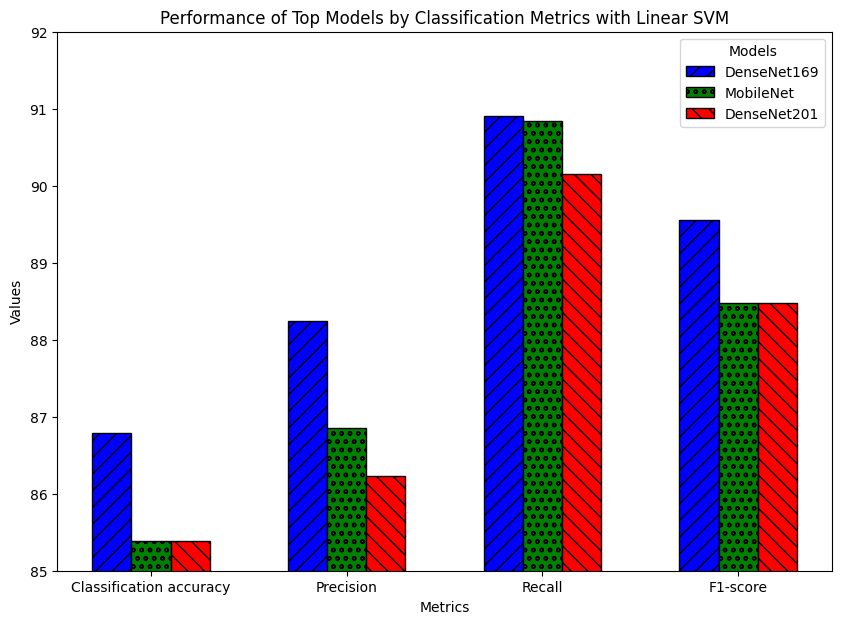

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the data
models = ['DenseNet169', 'MobileNet', 'DenseNet201']
metrics = ['Classification accuracy', 'Precision', 'Recall', 'F1-score']

# Data for each model and metric using the LINEAR kernel as an example
data = {
    'Classification accuracy': [86.79, 85.38, 85.38],
    'Precision': [88.24, 86.86, 86.23],
    'Recall': [90.91, 90.84, 90.15],
    'F1-score': [89.55, 88.48, 88.48]
}

# Convert data to DataFrame for easier manipulation
df = pd.DataFrame(data, index=models)

# Save to Excel
with pd.ExcelWriter('top_models_metrics.xlsx') as writer:
    df.to_excel(writer)

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
patterns = ['//', 'oo', '\\\\']  # Patterns for each model
colors = ['blue', 'green', 'red']  # Colors for each model
width = 0.2  # Width of the bars
ind = np.arange(len(metrics))  # The x locations for the groups

# Plotting bars for each metric and each model
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        ax.bar(ind[i] + j*width, df.loc[model, metric], width, 
               label=model if i == 0 else "", hatch=patterns[j], color=colors[j],edgecolor='black')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance of Top Models by Classification Metrics with Linear SVM')
ax.set_xticks(ind + width)  # Centering the tick marks under the group of bars
ax.set_xticklabels(metrics)
ax.legend(title='Models')

ax.set_ylim(85, 92)  # Set the y-limit from 85 to 100 as requested

# Save the figure as a high-resolution PDF in the 'results' folder
plt.savefig('results/Top-3 models.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_16108\232670360.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(names, rotation=45, ha="right")
C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_16108\232670360.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(names, rotation=45, ha="right")
C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_16108\232670360.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(names, rotation=45, ha="right")
C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_16108\232670360.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(name

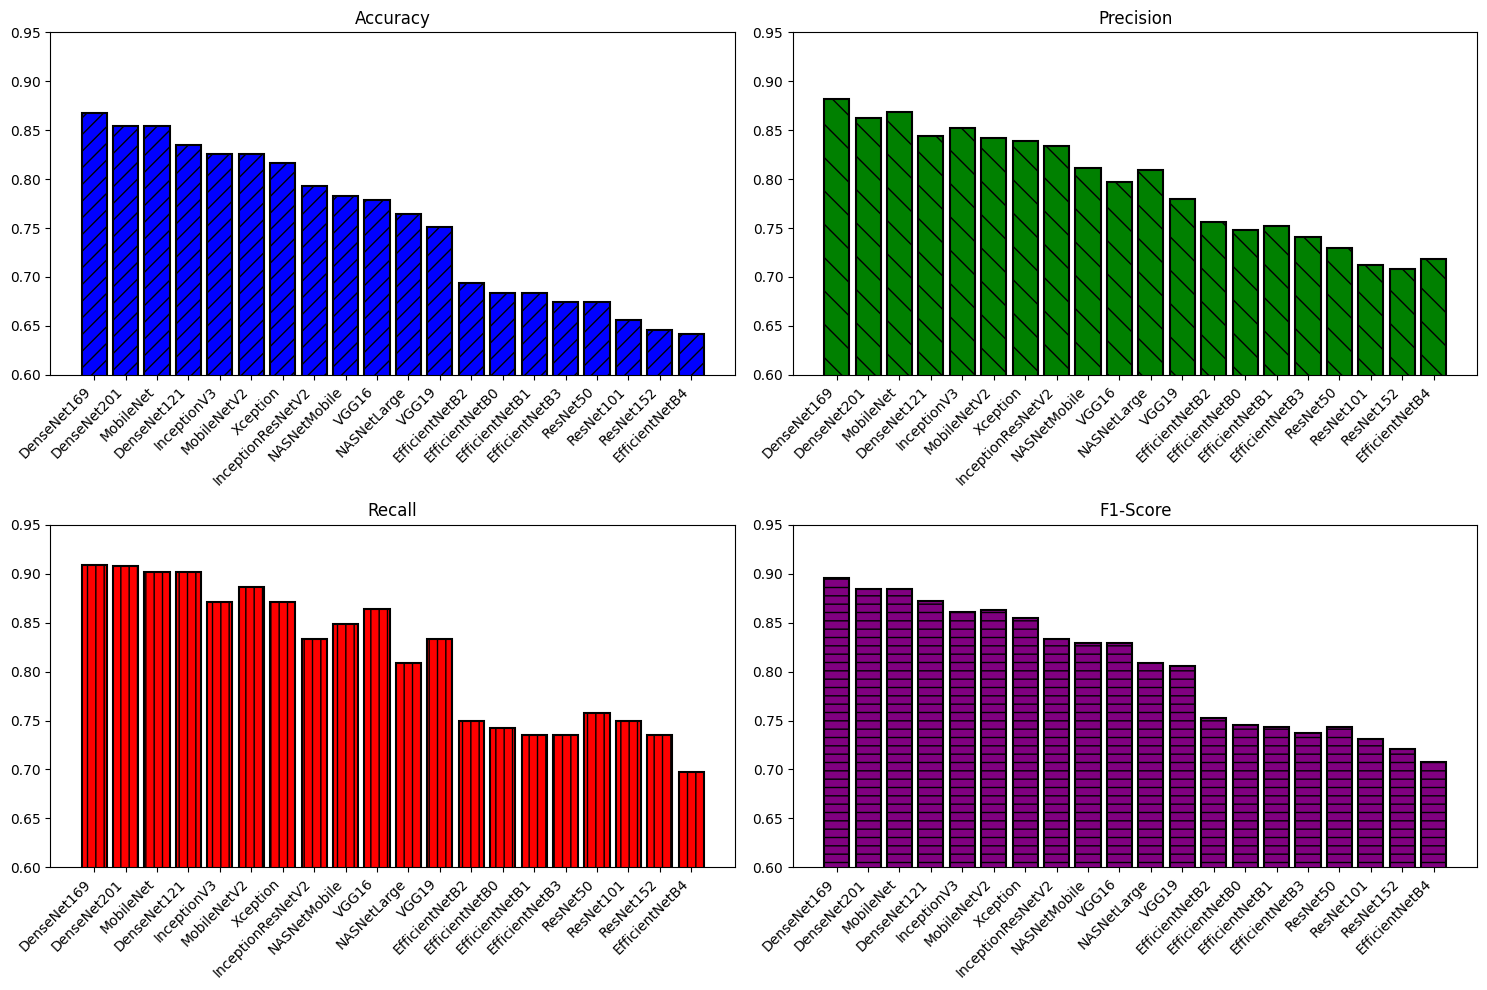

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the results directory exists
if not os.path.exists('results'):
    os.makedirs('results')

# Step 1: Read the Excel file into a DataFrame
df = pd.read_excel("results/all_results_linear.xlsx")

# Step 2: Extract rows where the Metric names are True Positive, True Negative, False Positive, and False Negative
metric_names = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
confusion_matrix_data = df[df['Metric'].isin(metric_names)]

# Initialize dictionaries to store metrics
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Calculate metrics for each model
for model_name in confusion_matrix_data['Model'].unique():
    model_data = confusion_matrix_data[confusion_matrix_data['Model'] == model_name]
    tp = model_data[model_data['Metric'] == 'True Positive']['Mean'].iloc[0]
    tn = model_data[model_data['Metric'] == 'True Negative']['Mean'].iloc[0]
    fp = model_data[model_data['Metric'] == 'False Positive']['Mean'].iloc[0]
    fn = model_data[model_data['Metric'] == 'False Negative']['Mean'].iloc[0]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    accuracy_dict[model_name] = accuracy
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall
    f1_dict[model_name] = f1

# Function to plot metrics in 2x2 subplot with adjusted y-limits and unique bar patterns and save the figure
def plot_all_metrics():
    metrics_dicts = [accuracy_dict, precision_dict, recall_dict, f1_dict]
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['blue', 'green', 'red', 'purple']
    hatches = ['//', '\\', '||', '--']  # Dense and distinct hatches
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the 2D axes array into 1D for easier iteration

    for i, (metric_dict, title, color, hatch) in enumerate(zip(metrics_dicts, titles, colors, hatches)):
        sorted_metrics = sorted(metric_dict.items(), key=lambda x: accuracy_dict[x[0]], reverse=True)
        names = [x[0] for x in sorted_metrics]
        values = [x[1] for x in sorted_metrics]
        
        bars = axes[i].bar(names, values, color=color, hatch=hatch, edgecolor='black', linewidth=1.5)  # Ensuring hatches are visible
        axes[i].set_title(title)
        axes[i].set_xticklabels(names, rotation=45, ha="right")
        axes[i].set_ylim([0.6, 0.95])  # Set y-axis limits

    plt.tight_layout()
    plt.savefig('results/metrics_linear_svm.pdf', format='pdf', dpi=300)
    plt.show()

# Plot all metrics in a 2x2 subplot and save as PDF
plot_all_metrics()


C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_19392\126889078.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=renewable_df, x='Year', y='Power generated in MGWs', ci=None, linewidth=2.5, color='green', marker='o', ax=axs[0, 1])
C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_19392\126889078.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=latest_renewable_df, x='Power generated in MGWs', y='Particular type', linewidth=2.5, ci=None, palette='viridis', order=latest_renewable_df.sort_values('Power generated in MGWs', ascending=False)['Particular type'], ax=axs[1, 0])
C:\Users\Dr Hafeez\AppData\Local\Temp\ipykernel_19392\126889078.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latest_renew

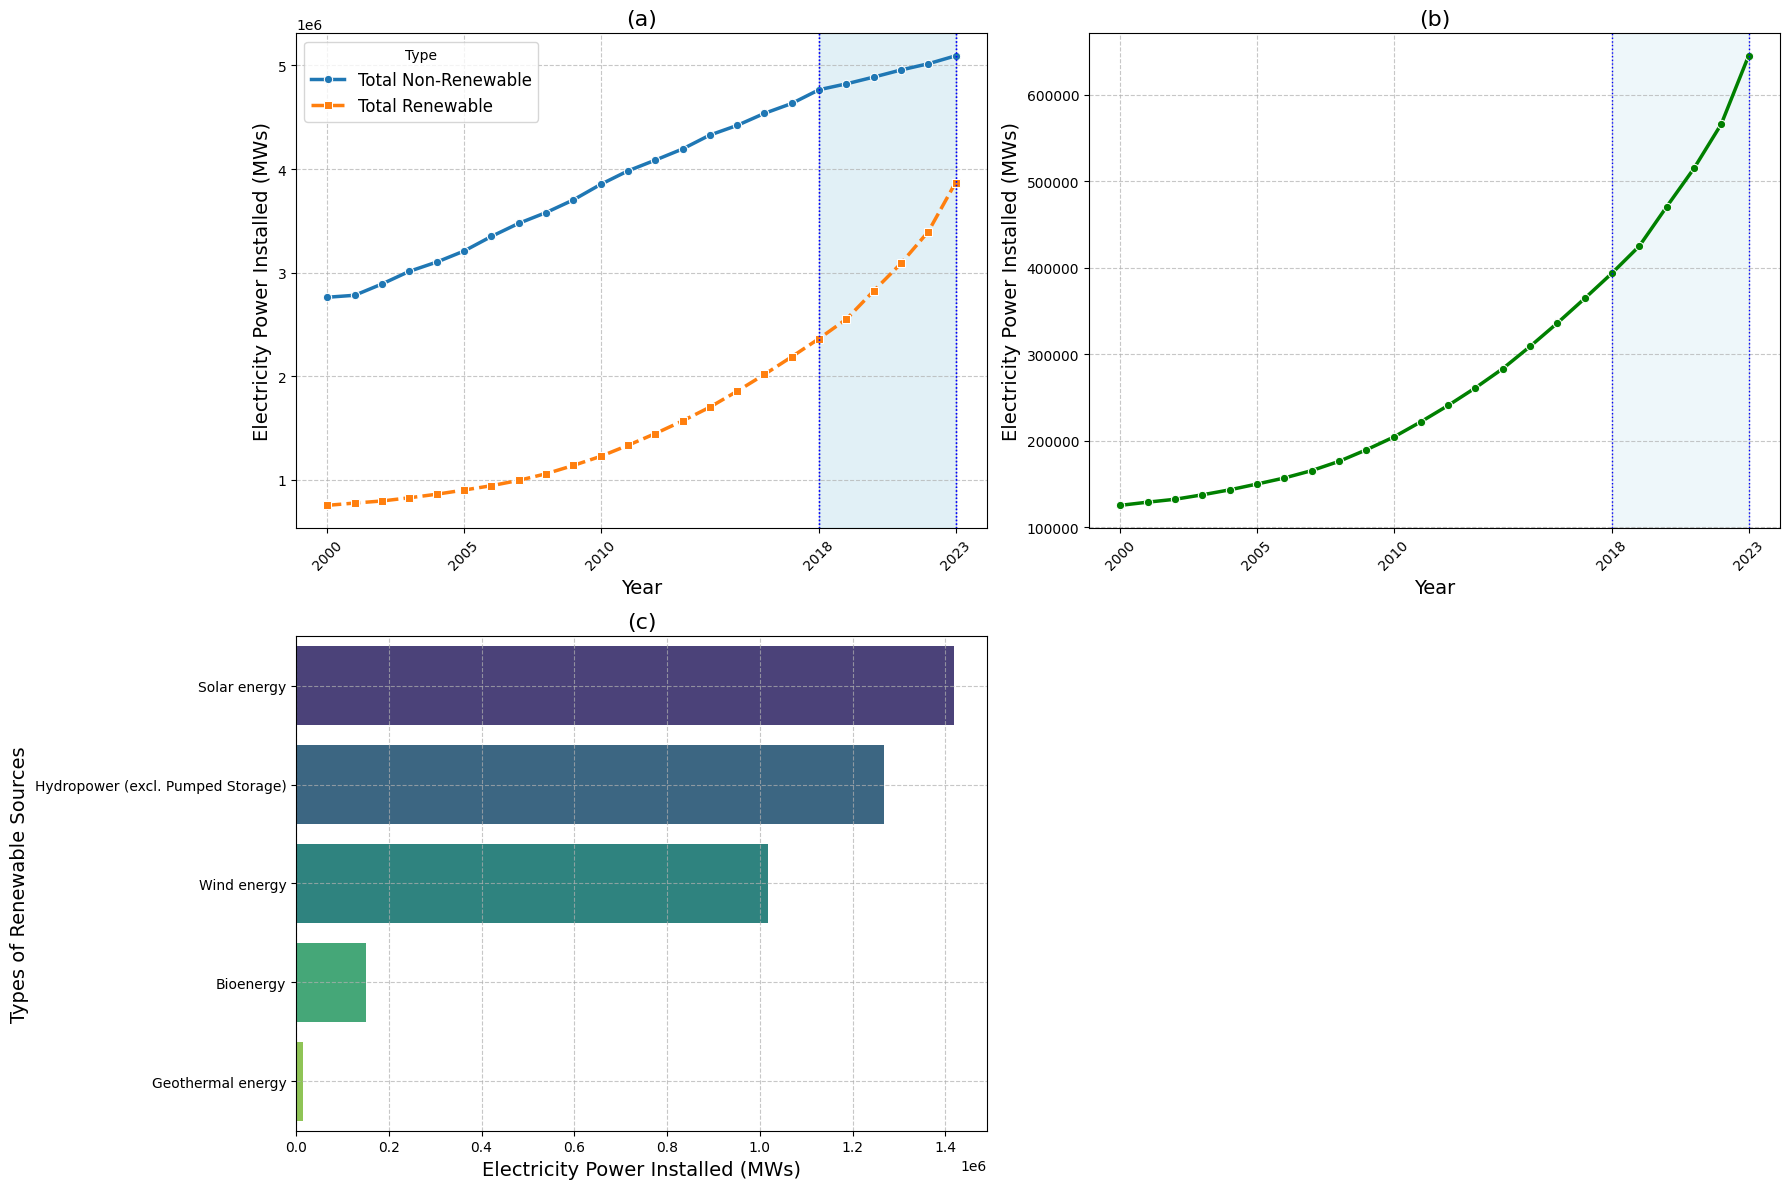

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    'Type': ['Total Non-Renewable']*96 + ['Total Renewable']*144,
    'Particular type': ['Fossil fuels']*24 + ['Nuclear']*24 + ['Other non-renewable energy']*24 + ['Pumped storage']*24 +
                      ['Bioenergy']*24 + ['Geothermal energy']*24 + ['Hydropower (excl. Pumped Storage)']*24 +
                      ['Marine energy']*24 + ['Solar energy']*24 + ['Wind energy']*24,
    'Year': list(range(2000, 2024))*10,
    'Power generated in MGWs': [2290384.614, 2313611.295, 2434431.72, 2555885.399, 2635941.961, 2734547.367, 2871542.398, 2992769.732, 3095873.953, 3211680.043, 3356792.345, 3480415.039, 3588745.752, 3694945.564, 3820045.603, 3911192.743, 4006701.217, 4097207.538, 4218483.599, 4273896.445, 4339984.01, 4400866.954, 4450473.011, 4522909.461, 358461.5, 360322.4, 366680.5, 366526.36, 373804.6, 377973.54, 378598.27, 379782.2, 378601.6, 379947.4, 381693.9, 386400.3, 378859.7, 376876.8, 383714.8, 383390.5, 398320.3, 398748.93, 405197.69, 403681.79, 399727.39, 401902.88, 401517.38, 399567.1, 28119.825, 26153.895, 6638.84, 7216.915, 7544.965, 8623.739, 9082.321, 8991.223, 9172.968, 9650.936, 12718.3, 11867.026, 12610.461, 13987.887, 14717.645, 14753.359, 15771.46, 17632.082, 22009.626, 24647.327, 25947.232, 29030.203, 30560.318, 31211.398, 84966.55, 80799.55, 82575.55, 82687.55, 83998.55, 86842.55, 89524.55, 93699.55, 95618.55, 100238.05, 100052.05, 103273.21, 105605.294, 107729.244, 109470.744, 111901.744, 116994.784, 119843.664, 120366.164, 120612.164, 122354.924, 125040.824, 134383.644, 139851.2444, 28330.12, 31489.125, 33077.425, 35302.886, 38259.582, 43528.635, 47468.337, 50623.092, 54572.964, 61509.109, 66226.215, 72652.922, 77618.447, 85014.713, 90843.273, 96842.107, 105674.616, 111410.236, 118607.736, 125244.338, 133199.851, 139510.667, 145896.296, 150261.17, 8272.7, 7960.91, 8113.45, 8188.35, 8208.88, 8556.116, 8758.696, 9012.936, 9318.816, 9754.316, 9914.316, 10058.666, 10517.666, 10786.366, 11248.716, 11846.966, 12172.974, 12729.613, 13196.361, 13824.041, 14157.341, 14432.038, 14652.955, 14845.935, 697169.998, 709059.493, 720271.816, 740387.163, 761767.442, 784161.201, 805564.569, 832413.899, 861919.028, 891731.386, 925877.098, 953921.047, 984711.803, 1029604.688, 1067333.698, 1099509.822, 1130040.822, 1151053.663, 1173728.032, 1192459.1, 1212924.784, 1235882.207, 1260882.706, 1267902.92, 238.25, 240.25, 243.25, 244.25, 243.25, 241.25, 240.25, 242.55, 245.55, 245.765, 250.095, 503.18, 509.909, 510.116, 513.527, 513.088, 523.708, 527.664, 527.654, 526.134, 524.539, 523.966, 525.124, 526.92, 1224.691, 1476.414, 1822.521, 2349.945, 3436.187, 4944.92, 6499.567, 8976.022, 15250.752, 23591.166, 41576.957, 73964.989, 104228.953, 141411.963, 180759.166, 229058.367, 301186.358, 396316.204, 492640.787, 595492.499, 728405.331, 873858.454, 1073135.531, 1418968.982, 16956.675, 23947.906, 30711.984, 38645.057, 47657.213, 58382.656, 73135.614, 91523.785, 115540.989, 150120.756, 181075.824, 220205.239, 267271.174, 299914.327, 349417.734, 416334.765, 466956.459, 515044.819, 563839.619, 622773.377, 733719.062, 824601.993, 901230.776, 1017198.786]
}

# Create DataFrame
df = pd.DataFrame(data)

# Aggregate data
total_df = df.groupby(['Type', 'Year']).sum().reset_index()

# Separate Renewable and Non-Renewable
renewable_df = df[df['Type'] == 'Total Renewable']
non_renewable_df = df[df['Type'] == 'Total Non-Renewable']

# Highlight regions with high gradient
def highlight_high_gradients(ax, x, y):
    start_year = 2018
    x = list(x)
    y = list(y)
    start_index = x.index(start_year)
    end_index = len(x) - 1
    
    ax.axvline(x[start_index], color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x[end_index], color='blue', linestyle='dotted', linewidth=1)
    ax.axvspan(x[start_index], x[end_index], color='lightblue', alpha=0.2)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Total Renewable vs Total Non-Renewable
sns.lineplot(data=total_df, x='Year', y='Power generated in MGWs', hue='Type', style='Type', markers=['o', 's'], linewidth=2.5, ax=axs[0, 0])
axs[0, 0].set_title('(a)', fontsize=16)
axs[0, 0].set_xlabel('Year', fontsize=14)
axs[0, 0].set_ylabel('Electricity Power Installed (MWs)', fontsize=14)
highlight_high_gradients(axs[0, 0], total_df[total_df['Type'] == 'Total Non-Renewable']['Year'], total_df[total_df['Type'] == 'Total Non-Renewable']['Power generated in MGWs'])
highlight_high_gradients(axs[0, 0], total_df[total_df['Type'] == 'Total Renewable']['Year'], total_df[total_df['Type'] == 'Total Renewable']['Power generated in MGWs'])
axs[0, 0].legend(title='Type', fontsize=12)
axs[0, 0].grid(True, linestyle='--', alpha=0.7)
axs[0, 0].set_xticks(list(range(2000, 2015, 5)) + [2018, 2023])
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Increasing Trend in Total Renewable Power Generation
sns.lineplot(data=renewable_df, x='Year', y='Power generated in MGWs', ci=None, linewidth=2.5, color='green', marker='o', ax=axs[0, 1])
axs[0, 1].set_title('(b)', fontsize=16)
axs[0, 1].set_xlabel('Year', fontsize=14)
axs[0, 1].set_ylabel('Electricity Power Installed (MWs)', fontsize=14)
highlight_high_gradients(axs[0, 1], renewable_df['Year'], renewable_df['Power generated in MGWs'])
axs[0, 1].grid(True, linestyle='--', alpha=0.7)
axs[0, 1].set_xticks(list(range(2000, 2015, 5)) + [2018, 2023])
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Sources of Renewable Energy in Latest Year
latest_year = renewable_df['Year'].max()
latest_renewable_df = renewable_df[(renewable_df['Year'] == latest_year) & 
                                    (~renewable_df['Particular type'].isin(['Marine energy']))]

sns.barplot(data=latest_renewable_df, x='Power generated in MGWs', y='Particular type', linewidth=2.5, ci=None, palette='viridis', order=latest_renewable_df.sort_values('Power generated in MGWs', ascending=False)['Particular type'], ax=axs[1, 0])
axs[1, 0].set_title('(c)', fontsize=16)
axs[1, 0].set_xlabel('Electricity Power Installed (MWs)', fontsize=14)
axs[1, 0].set_ylabel('Types of Renewable Sources', fontsize=14)
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplot
fig.delaxes(axs[1, 1])

# Adjust layout
plt.tight_layout()
# Save the figure as a high-resolution PDF
plt.savefig('results/Renewables.pdf', dpi=300)
plt.show()